# Activity classification on the Capture24 dataset

<img src="../wrist_accelerometer.jpg" width="300"/>

The Capture24 dataset consists of wrist-worn accelerometer data
collected from about 150 participants. Each participant wore the device along
with a body camera for about 24 hrs. Human annotators annotated the
accelerometer data by matching the timestamps of the accelerometer and
camera. The accelerometer mearures acceleration in the three axes (x, y, z),
with a sampling rate of 100Hz.

## Setup

In [114]:
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm

# For reproducibility
np.random.seed(42)


## Load and inspect the dataset

In [115]:

# Path to capture24 dataset
CAPTURE24_DIR = '../../anonymised_capture24'

# Let's see what's in it
print(f'Content of {CAPTURE24_DIR}')
print(os.listdir(CAPTURE24_DIR))

# Let's load and inspect one participant
data = pd.read_pickle(CAPTURE24_DIR+'/040.pkl')
print(f'\nParticipant 040:')
print(data)

print('\nWith NaNs removed...')
data.dropna(inplace=True)
print(data)

print("\nUnique annotations")
print(data['annotation'].unique())


Content of ../../anonymised_capture24
['040.pkl', '077.pkl']

Participant 040:
                                         x         y         z annotation
time                                                                     
2015-03-02 11:21:55.542000+00:00  0.263613  0.086647 -0.953598       <NA>
2015-03-02 11:21:55.552000+00:00 -0.698853  0.382365 -0.730780       <NA>
2015-03-02 11:21:55.562000+00:00 -0.793521  0.429057 -0.651201       <NA>
2015-03-02 11:21:55.572000+00:00 -0.856634  0.382365 -0.555708       <NA>
2015-03-02 11:21:55.582000+00:00 -0.935525  0.366800 -0.444298       <NA>
...                                    ...       ...       ...        ...
2015-03-05 15:50:55.492000+00:00 -0.161971  0.172636  1.002865       <NA>
2015-03-05 15:50:55.502000+00:00 -0.139881  0.197539  0.996499       <NA>
2015-03-05 15:50:55.512000+00:00 -0.073326  0.088307  1.024857       <NA>
2015-03-05 15:50:55.522000+00:00  0.043145 -0.172886  1.036288       <NA>
2015-03-05 15:50:55.532000+00:00 

The annotations are based on the [Compendium of Physical
Activity](https://sites.google.com/site/compendiumofphysicalactivities/home).
There are more than 100 unique annotations identified in the whole dataset.
As you can see, the annotations can be very detailed. 

For our purposes, it is enough to translate the annotations into a simpler
set of labels. The provided *annotation-label-dictionary.csv* file contains
a few possible labelling that were used in previous works.

In [116]:
ANNO_LABEL_DICT = '../../anonymised-label-dictionary.csv'

anno_label_dict = pd.read_csv(ANNO_LABEL_DICT, dtype='string')
print("Annotation-Label Dictionary")
print(anno_label_dict)

# Translate annotations using Willetts' labels
anno_label_dict.set_index('annotation', inplace=True)
data['label'] = anno_label_dict.loc[data['annotation'], 'label:Willetts2018'].values

print('\nLabel distribution (Willetts)')
print(data['label'].value_counts())


Annotation-Label Dictionary
                                            annotation label:Willetts2018  \
0                               7030 sleeping;MET 0.95              sleep   
1    occupation;office and administrative support;1...          sit-stand   
2    home activity;household chores;preparing meals...              mixed   
3    occupation;office and administrative support;1...          sit-stand   
4    home activity;miscellaneous;sitting;9060 sitti...          sit-stand   
..                                                 ...                ...   
160  transportation;walking;17250 walking as the si...              mixed   
161  transportation;walking;17270 walking as the si...            walking   
162  transportation;public transportation;16016 rid...            vehicle   
163      household-chores;sitstand+lowactivity;MET 2.8              mixed   
164                                    vehicle;MET 1.3            vehicle   

    label:Doherty2018 label:Walmsley2020  
0   

To continue, let's extract 30-sec windows of activity &mdash; these will make up
the learning dataset.

In [117]:

def splitby_timegap(data, gap=1):
    split_id = (data.index.to_series().diff() > pd.Timedelta(gap, 'S')).cumsum()
    splits = data.groupby(by=split_id)
    return splits

def pick_majority(alist, criteria_fn):
    crit = [criteria_fn(_) for _ in alist]
    unq, cnt = np.unique(crit, return_counts=True)
    maj = unq[np.argmax(cnt)]
    return [a for a, b in zip(alist, crit) if b == maj]

def extract_windows(data, window_len, stack=True):
    X, Y = [], []
    for _, data_split in splitby_timegap(data):
        for _, window in data_split.groupby(pd.Grouper(freq=window_len)):
            X.append(window[['x','y','z']].values)
            Y.append(window['label'].values)
    # Discard windows of irregular length by picking the majority length
    X, Y = pick_majority(X, len), pick_majority(Y, len)
    # Also pick majority label in each window
    Y = [stats.mode(_)[0] for _ in Y]
    if stack:
        X, Y = np.stack(X), np.stack(Y).ravel()
    return X, Y
    
# Extract 30s windows
X, Y = extract_windows(data, window_len='30s')
print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('\nLabel distribution (windowed)')
print(pd.Series(Y).value_counts())


X shape: (2083, 3000, 3)
Y shape: (2083,)

Label distribution (windowed)
sit-stand    835
sleep        620
walking      222
mixed        212
vehicle      167
bicycling     27
dtype: int64


We observe some imbalance in the data, which will likely be an issue
later for the machine learning model.

# Visualization
Visualization helps us get some insight and anticipate the difficulties that may arise.
Let's visualize some examples for each activity label. 

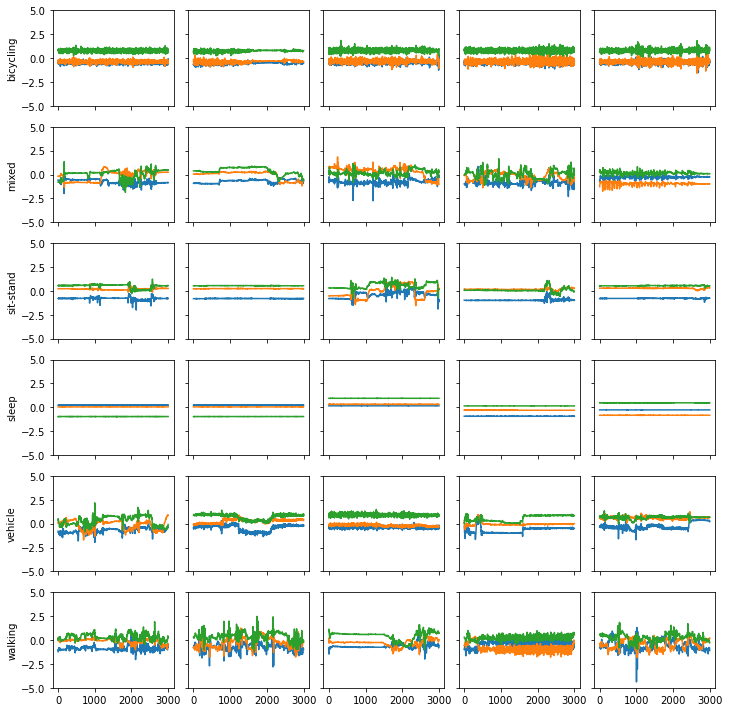

In [118]:
NPLOTS = 5
unqY = np.unique(Y)
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(10,10))
for y, row in zip(unqY, axs):
    idxs = np.random.choice(np.where(Y==y)[0], size=NPLOTS)
    row[0].set_ylabel(y)
    for x, ax in zip(X[idxs], row):
        ax.plot(x)
        ax.set_ylim(-5,5)
fig.tight_layout()
fig.show()


From the plots, it would seem that it should be pretty easy to classify "sleep"
and maybe "sit-stand".

Next, let's try to visualize the data in a scatter-plot.
The most standard approach to visualize high-dimensional points is to
scatter-plot the first two principal components of the data.

## PCA visualization 


In [119]:

def scatter_plot(X, Y):
    unqY = np.unique(Y)
    fig, ax = plt.subplots()
    for y in unqY:
        X_y = X[Y==y]
        ax.scatter(X_y[:,0], X_y[:,1], label=y, alpha=.5, s=10)
    fig.legend()
    fig.show()

print("Plotting first two PCA components...")
scaler = preprocessing.StandardScaler()  # PCA requires normalized data
X_scaled = scaler.fit_transform(X.reshape(X.shape[0],-1))
pca = decomposition.PCA(n_components=2)  # two components
X_pca = pca.fit_transform(X_scaled)
scatter_plot(X_pca, Y)


Plotting first two PCA components...


The scatter-plot seems to support our guess as "sleep" dots are well clustered
together.

## t-SNE visualization
What if we want to visualize more components? A popular high-dimensional data
visualization tool is _t-distributed stochastic neighbor embedding_ (t-SNE).
Let's visualize 64 principal components.

*Note: this may take a while*

Plotting t-SNE on 64 PCA components...


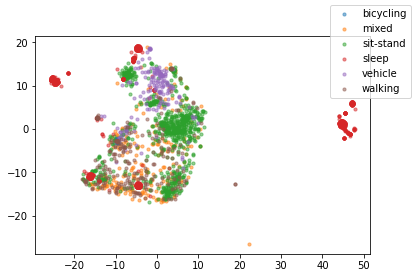

In [120]:
print("Plotting t-SNE on 64 PCA components...")
pca = decomposition.PCA(n_components=64)  # 64 components this time
X_pca = pca.fit_transform(X_scaled)
tsne = manifold.TSNE(n_components=2,  # project down to 2 components
    init='random', random_state=42, perplexity=100)
X_tsne_pca = tsne.fit_transform(X_pca)
scatter_plot(X_tsne_pca, Y)


# Feature extraction
Let's extract some commonly used timeseries features from each window. Feel
free to add your own features below.

In [121]:

def extract_features(X):
    X_feats = []

    for xyz in X:
        feats = {}
        feats['xMean'], feats['yMean'], feats['zMean'] = np.mean(xyz, axis=0)
        feats['xStd'], feats['yStd'], feats['zStd'] = np.std(xyz, axis=0)
        feats['xRange'], feats['yRange'], feats['zRange'] = np.ptp(xyz, axis=0)

        x, y, z = xyz.T

        with np.errstate(divide='ignore', invalid='ignore'):  # ignore div by 0 warnings
            feats['xyCorr'] = np.nan_to_num(np.corrcoef(x, y)[0,1])
            feats['yzCorr'] = np.nan_to_num(np.corrcoef(y, z)[0,1])
            feats['zxCorr'] = np.nan_to_num(np.corrcoef(z, x)[0,1])

        m = np.linalg.norm(xyz, axis=1)

        feats['mean'] = np.mean(m)
        feats['std'] = np.std(m)
        feats['mad'] = stats.median_abs_deviation(m)
        feats['kurt'] = stats.kurtosis(m)
        feats['skew'] = stats.skew(m)

        X_feats.append(feats)

    X_feats = pd.DataFrame(X_feats)

    return X_feats

X_feats = extract_features(X)
print(X_feats)


         xMean     yMean     zMean      xStd      yStd      zStd    xRange  \
0    -0.187497  0.038857  0.986675  0.007032  0.002463  0.006584  0.015778   
1    -0.187924  0.038962  0.986974  0.006964  0.002344  0.006595  0.015778   
2    -0.187647  0.038958  0.986678  0.006961  0.002359  0.006546  0.031556   
3    -0.186767  0.038795  0.987432  0.006921  0.002628  0.006581  0.018934   
4    -0.186560  0.038750  0.987492  0.006945  0.002675  0.006631  0.028687   
...        ...       ...       ...       ...       ...       ...       ...   
2078  0.381115 -0.113753 -0.921602  0.006546  0.004604  0.006391  0.015778   
2079  0.381558 -0.113633 -0.921360  0.006458  0.004712  0.006369  0.015883   
2080  0.387446 -0.110531 -0.919307  0.004051  0.006286  0.005358  0.015883   
2081  0.388602 -0.110658 -0.918765  0.002028  0.006158  0.004834  0.018934   
2082  0.388695 -0.110439 -0.918722  0.001843  0.006186  0.004718  0.031556   

        yRange    zRange    xyCorr    yzCorr    zxCorr      mea

Let's visualize the data again using t-SNE, but this time using the extracted features
rather than the principal components.

*Note: this may take a while*

In [122]:
print("Plotting t-SNE on extracted features...")
tsne = manifold.TSNE(n_components=2,
    init='random', random_state=42, perplexity=100)
X_tsne_feats = tsne.fit_transform(X_feats)
scatter_plot(X_tsne_feats, Y)


Plotting t-SNE on extracted features...


# Activity classification
Let's train a balanced random forest on the extracted features to perform
activity classification. We use the implementation from
[`imbalanced-learn`](https://imbalanced-learn.org/stable/) package, which has better
support for imbalanced datasets.

In [123]:
clf = BalancedRandomForestClassifier(
    n_estimators=1000,
    replacement=True,
    sampling_strategy='not minority',
    n_jobs=4,
    random_state=42,
)
clf.fit(X_feats, Y)

print('\nClassifier performance in training set')
print(metrics.classification_report(Y, clf.predict(X_feats)))



Classifier performance in training set
              precision    recall  f1-score   support

   bicycling       0.49      1.00      0.66        27
       mixed       0.55      0.74      0.63       212
   sit-stand       0.91      0.77      0.83       835
       sleep       0.96      0.95      0.95       620
     vehicle       0.66      0.89      0.76       167
     walking       0.60      0.55      0.57       222

    accuracy                           0.81      2083
   macro avg       0.70      0.82      0.73      2083
weighted avg       0.83      0.81      0.81      2083



The classification in-sample is just acceptable. This suggests
that we might need to add more discriminative features. Let's load another
subject to test and get the true (out-of-sample) performance.

In [124]:

# Load another participant data
data2 = pd.read_pickle(CAPTURE24_DIR+'/077.pkl').dropna()
# Translate annotations
data2['label'] = anno_label_dict.loc[data2['annotation'], 'label:Willetts2018'].values
# Extract 30s windows
X2, Y2 = extract_windows(data2, window_len='30s')
# Extract features
X2_feats = extract_features(X2)

print('\nClassifier performance on held-out subject')
print(metrics.classification_report(Y2, clf.predict(X2_feats)))



Classifier performance on held-out subject
              precision    recall  f1-score   support

   bicycling       0.00      0.00      0.00         0
       mixed       0.51      0.35      0.42       572
   sit-stand       0.81      0.40      0.54       535
       sleep       0.87      0.93      0.90       950
     vehicle       0.12      0.89      0.21        80
     walking       0.17      0.06      0.09       206

    accuracy                           0.59      2343
   macro avg       0.41      0.44      0.36      2343
weighted avg       0.68      0.59      0.60      2343

/home/vtx027/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The overall classification performance is much worse on the held-out subject.
As we expected, "sleep" classification remains quite good (f1-score of 0.90).

### Exercise
So far we've only looked at one subject. To use the whole dataset, repeat the
procedure per subject, but beware of memory issues. Below is a sample code 
that uses `np.memmap` to store the windows directly onto disk. You're
encouraged to re-run this notebook on more subjects, and to explore
different labels or even define your own by modifying the file
*annotation-label-dictionary.csv*.


In [125]:

X_DTYPE = 'f8'
Y_DTYPE = 'S20'
X_ROWSHAPE = (3000,3)


def multi_extract_windows(outdir):

    n_old = n_new = 0
    is_first = True

    X_pth = os.path.join(outdir, 'X.dat')
    Y_pth = os.path.join(outdir, 'Y.dat')

    for datafile in tqdm(os.listdir(CAPTURE24_DIR)):

        mode = 'r+'
        if is_first:
            is_first = False
            mode = 'w+'

        data = pd.read_pickle(CAPTURE24_DIR+'/'+datafile).dropna()
        data['label'] = anno_label_dict.loc[data['annotation'], 'label:Willetts2018'].values
        X, Y = extract_windows(data, window_len='30s')
        n_new = n_old + len(X)
        Xf = np.memmap(X_pth, mode=mode, dtype=X_DTYPE, shape=(n_new,) + X_ROWSHAPE)
        Yf = np.memmap(Y_pth, mode=mode, dtype=Y_DTYPE, shape=(n_new,))
        Xf[n_old:], Yf[n_old:] = X, Y
        Xf.flush(); Yf.flush()

        n_old = n_new

    X_shape = (n_new,) + X_ROWSHAPE
    Y_shape = (n_new,)
    print(f'Output files saved in {outdir}')
    print(os.listdir(outdir))
    print('X shape:', Xf.shape)
    print('Y shape:', Yf.shape)

    return {'X_pth':X_pth, 'Y_pth':Y_pth, 'X_shape':X_shape, 'Y_shape':Y_shape}
    
# Extract windows, save in dataset/
OUTDIR = 'dataset/'
os.system(f'mkdir -p {OUTDIR}')
info = multi_extract_windows(OUTDIR)

# Check that extraction worked
print('\nReloading memmap data')
X = np.memmap(info['X_pth'], mode='r', dtype=X_DTYPE, shape=info['X_shape'])
Y = np.memmap(info['Y_pth'], mode='r', dtype=Y_DTYPE, shape=info['Y_shape'])
print('X shape:', X.shape)
print('Y shape:', Y.shape)



Output files saved in dataset/
['Y.dat', 'X.dat']
X shape: (4426, 3000, 3)
Y shape: (4426,)

Reloading memmap data
X shape: (4426, 3000, 3)
Y shape: (4426,)


## References
- Ideas for hand-crafted features:
    - [Physical activity classification using the GENEA wrist-worn accelerometer](https://www.ncbi.nlm.nih.gov/pubmed/21988935)
    - [A universal, accurate intensity-based classification of different physical activities using raw data of accelerometer](https://www.ncbi.nlm.nih.gov/pubmed/24393233)
    - [Activity recognition using a single accelerometer placed at the wrist or ankle](https://www.ncbi.nlm.nih.gov/pubmed/23604069)
    - [Hip and Wrist Accelerometer Algorithms for Free-Living Behavior Classification](https://www.ncbi.nlm.nih.gov/pubmed/26673126)


In [126]:

# Path to capture24 dataset
CAPTURE24_DIR = '../../anonymised_capture24'

# Let's see what's in it
print(f'Content of {CAPTURE24_DIR}')
print(os.listdir(CAPTURE24_DIR))

# Let's load and inspect one participant
data = pd.read_pickle(CAPTURE24_DIR+'/040.pkl')
print(f'\nParticipant 040:')
print(data)

print('\nWith NaNs removed...')
data.dropna(inplace=True)
print(data)

print("\nUnique annotations")
print(pd.Series(data['annotation'].unique()))


Content of ../../anonymised_capture24
['040.pkl', '077.pkl']

Participant 040:
                                         x         y         z annotation
time                                                                     
2015-03-02 11:21:55.542000+00:00  0.263613  0.086647 -0.953598       <NA>
2015-03-02 11:21:55.552000+00:00 -0.698853  0.382365 -0.730780       <NA>
2015-03-02 11:21:55.562000+00:00 -0.793521  0.429057 -0.651201       <NA>
2015-03-02 11:21:55.572000+00:00 -0.856634  0.382365 -0.555708       <NA>
2015-03-02 11:21:55.582000+00:00 -0.935525  0.366800 -0.444298       <NA>
...                                    ...       ...       ...        ...
2015-03-05 15:50:55.492000+00:00 -0.161971  0.172636  1.002865       <NA>
2015-03-05 15:50:55.502000+00:00 -0.139881  0.197539  0.996499       <NA>
2015-03-05 15:50:55.512000+00:00 -0.073326  0.088307  1.024857       <NA>
2015-03-05 15:50:55.522000+00:00  0.043145 -0.172886  1.036288       <NA>
2015-03-05 15:50:55.532000+00:00 

# Activity classification on the Capture24 dataset

<img src="../wrist_accelerometer.jpg" width="300"/>

The Capture24 dataset consists of wrist-worn accelerometer data
collected from about 150 participants. 
Along with the accelerometer, each participant wore a body camera during the
daytime, and used a sleep diary to register sleep and wake-up times.
The total wear time per participant was about 24 hours.
The accelerometer mearures acceleration in the three axes (x, y, z), and has
a sampling rate of 100Hz.
The body camera has a temporal resolution of 1 picture every 20 seconds.
Human annotators annotated the accelerometer timestamps by inspecting
the body camera images to infer the activities performed, and the sleep
diary for the sleep periods.

## Setup

In [127]:
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm

# For reproducibility
np.random.seed(42)


## Load and inspect the dataset

In [128]:

# Path to capture24 dataset
CAPTURE24_DIR = '../../anonymised_capture24/'

# Let's see what's in it
print(f'Content of {CAPTURE24_DIR}')
print(os.listdir(CAPTURE24_DIR))

# Let's load and inspect one participant
data = pd.read_pickle(CAPTURE24_DIR+'040.pkl')
print(f'\nParticipant 040:')
print(data)

print('\nWith NaNs removed...')
data.dropna(inplace=True)
print(data)

print("\nUnique annotations")
print(pd.Series(data['annotation'].unique()))


Content of ../../anonymised_capture24/
['040.pkl', '077.pkl']

Participant 040:
                                         x         y         z annotation
time                                                                     
2015-03-02 11:21:55.542000+00:00  0.263613  0.086647 -0.953598       <NA>
2015-03-02 11:21:55.552000+00:00 -0.698853  0.382365 -0.730780       <NA>
2015-03-02 11:21:55.562000+00:00 -0.793521  0.429057 -0.651201       <NA>
2015-03-02 11:21:55.572000+00:00 -0.856634  0.382365 -0.555708       <NA>
2015-03-02 11:21:55.582000+00:00 -0.935525  0.366800 -0.444298       <NA>
...                                    ...       ...       ...        ...
2015-03-05 15:50:55.492000+00:00 -0.161971  0.172636  1.002865       <NA>
2015-03-05 15:50:55.502000+00:00 -0.139881  0.197539  0.996499       <NA>
2015-03-05 15:50:55.512000+00:00 -0.073326  0.088307  1.024857       <NA>
2015-03-05 15:50:55.522000+00:00  0.043145 -0.172886  1.036288       <NA>
2015-03-05 15:50:55.532000+00:00

The annotations are based on the [Compendium of Physical
Activity](https://sites.google.com/site/compendiumofphysicalactivities/home).
There are more than 100 unique annotations identified in the whole dataset.
As you can see, the annotations can be very detailed. 

For our purposes, it is enough to translate the annotations into a simpler
set of labels. The provided *annotation-label-dictionary.csv* file contains
a few options that were used in previous works.

In [129]:
ANNO_LABEL_DICT = '../../anonymised-label-dictionary.csv'

anno_label_dict = pd.read_csv(ANNO_LABEL_DICT, dtype='string')
print("Annotation-Label Dictionary")
print(anno_label_dict)

# Translate annotations using Willetts' labels
anno_label_dict.set_index('annotation', inplace=True)
data['label'] = anno_label_dict.loc[data['annotation'], 'label:Willetts2018'].values

print('\nLabel distribution (Willetts)')
print(data['label'].value_counts())


Annotation-Label Dictionary
                                            annotation label:Willetts2018  \
0                               7030 sleeping;MET 0.95              sleep   
1    occupation;office and administrative support;1...          sit-stand   
2    home activity;household chores;preparing meals...              mixed   
3    occupation;office and administrative support;1...          sit-stand   
4    home activity;miscellaneous;sitting;9060 sitti...          sit-stand   
..                                                 ...                ...   
160  transportation;walking;17250 walking as the si...              mixed   
161  transportation;walking;17270 walking as the si...            walking   
162  transportation;public transportation;16016 rid...            vehicle   
163      household-chores;sitstand+lowactivity;MET 2.8              mixed   
164                                    vehicle;MET 1.3            vehicle   

    label:Doherty2018 label:Walmsley2020  
0   

To continue, let's extract 30-sec windows of activity &mdash; these will make up
the learning dataset.

In [130]:

def splitby_timegap(data, gap=1):
    split_id = (data.index.to_series().diff() > pd.Timedelta(gap, 'S')).cumsum()
    splits = data.groupby(by=split_id)
    return splits

def pick_majority(alist, criteria_fn):
    crit = [criteria_fn(_) for _ in alist]
    unq, cnt = np.unique(crit, return_counts=True)
    maj = unq[np.argmax(cnt)]
    return [a for a, b in zip(alist, crit) if b == maj]

def extract_windows(data, window_len, stack=True):
    X, Y = [], []
    for _, data_split in splitby_timegap(data):
        for _, window in data_split.groupby(pd.Grouper(freq=window_len)):
            X.append(window[['x','y','z']].values)
            Y.append(window['label'].values)
    # Discard windows of irregular length by picking the majority length
    X, Y = pick_majority(X, len), pick_majority(Y, len)
    # Also pick majority label in each window
    Y = [stats.mode(_)[0] for _ in Y]
    if stack:
        X, Y = np.stack(X), np.stack(Y).ravel()
    return X, Y
    
# Extract 30s windows
X, Y = extract_windows(data, window_len='30s')
print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('\nLabel distribution (windowed)')
print(pd.Series(Y).value_counts())


X shape: (2083, 3000, 3)
Y shape: (2083,)

Label distribution (windowed)
sit-stand    835
sleep        620
walking      222
mixed        212
vehicle      167
bicycling     27
dtype: int64


We observe some imbalance in the data. This will likely be an issue
later for the machine learning model.

# Visualization
Visualization helps us get some insight and anticipate the difficulties that may arise.
Let's visualize some examples for each activity label. 

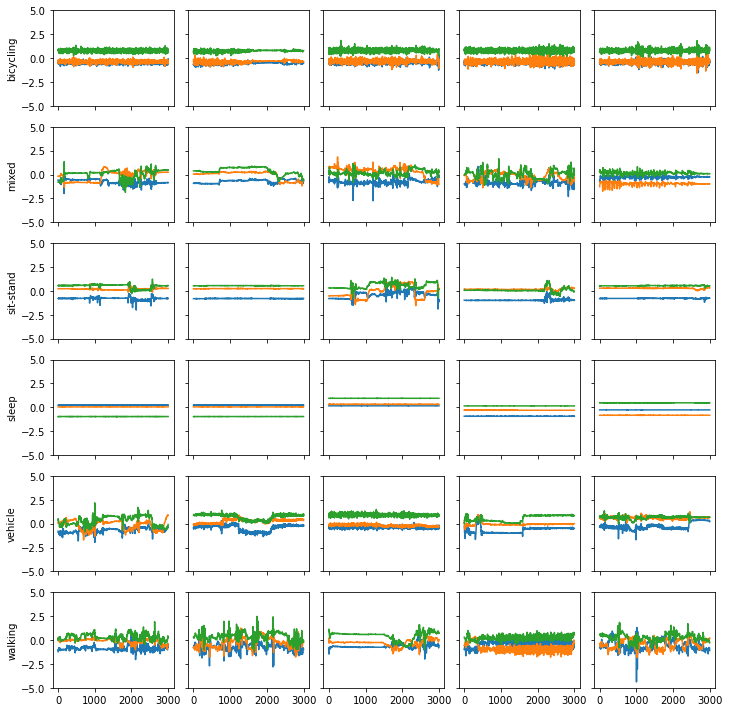

In [131]:
NPLOTS = 5
unqY = np.unique(Y)
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(10,10))
for y, row in zip(unqY, axs):
    idxs = np.random.choice(np.where(Y==y)[0], size=NPLOTS)
    row[0].set_ylabel(y)
    for x, ax in zip(X[idxs], row):
        ax.plot(x)
        ax.set_ylim(-5,5)
fig.tight_layout()
fig.show()


From the plots, it would seem that it should be pretty easy to classify "sleep"
and maybe "sit-stand".

Next, let's try to visualize the data in a scatter-plot.
The most standard approach to visualize high-dimensional points is to
scatter-plot the first two principal components of the data.

## PCA visualization 


In [132]:

def scatter_plot(X, Y):
    unqY = np.unique(Y)
    fig, ax = plt.subplots()
    for y in unqY:
        X_y = X[Y==y]
        ax.scatter(X_y[:,0], X_y[:,1], label=y, alpha=.5, s=10)
    fig.legend()
    fig.show()

print("Plotting first two PCA components...")
scaler = preprocessing.StandardScaler()  # PCA requires normalized data
X_scaled = scaler.fit_transform(X.reshape(X.shape[0],-1))
pca = decomposition.PCA(n_components=2)  # two components
X_pca = pca.fit_transform(X_scaled)
scatter_plot(X_pca, Y)


Plotting first two PCA components...


The "sleep" dots are well clustered together, which seems to support our
guess that it should be easier to classify.

## t-SNE visualization
What if we want to visualize more components? A popular high-dimensional data
visualization tool is _t-distributed stochastic neighbor embedding_ (t-SNE).
Let's visualize 64 principal components.

*Note: this may take a while*

Plotting t-SNE on 64 PCA components...


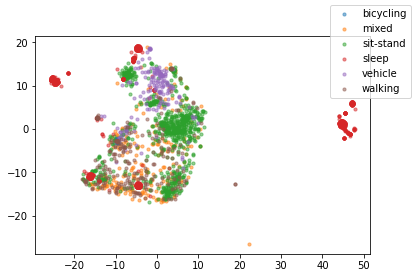

In [133]:
print("Plotting t-SNE on 64 PCA components...")
pca = decomposition.PCA(n_components=64)  # 64 components this time
X_pca = pca.fit_transform(X_scaled)
tsne = manifold.TSNE(n_components=2,  # project down to 2 components
    init='random', random_state=42, perplexity=100)
X_tsne_pca = tsne.fit_transform(X_pca)
scatter_plot(X_tsne_pca, Y)


# Feature extraction
Let's extract some commonly used timeseries features from each activity
window. Feel free to modify and add your own features below.

In [134]:

def extract_features(X):
    X_feats = []

    for xyz in X:
        feats = {}
        feats['xMean'], feats['yMean'], feats['zMean'] = np.mean(xyz, axis=0)
        feats['xStd'], feats['yStd'], feats['zStd'] = np.std(xyz, axis=0)
        feats['xRange'], feats['yRange'], feats['zRange'] = np.ptp(xyz, axis=0)

        x, y, z = xyz.T

        with np.errstate(divide='ignore', invalid='ignore'):  # ignore div by 0 warnings
            feats['xyCorr'] = np.nan_to_num(np.corrcoef(x, y)[0,1])
            feats['yzCorr'] = np.nan_to_num(np.corrcoef(y, z)[0,1])
            feats['zxCorr'] = np.nan_to_num(np.corrcoef(z, x)[0,1])

        m = np.linalg.norm(xyz, axis=1)

        feats['mean'] = np.mean(m)
        feats['std'] = np.std(m)
        feats['mad'] = stats.median_abs_deviation(m)
        feats['kurt'] = stats.kurtosis(m)
        feats['skew'] = stats.skew(m)

        X_feats.append(feats)

    X_feats = pd.DataFrame(X_feats)

    return X_feats

X_feats = extract_features(X)
print(X_feats)


         xMean     yMean     zMean      xStd      yStd      zStd    xRange  \
0    -0.187497  0.038857  0.986675  0.007032  0.002463  0.006584  0.015778   
1    -0.187924  0.038962  0.986974  0.006964  0.002344  0.006595  0.015778   
2    -0.187647  0.038958  0.986678  0.006961  0.002359  0.006546  0.031556   
3    -0.186767  0.038795  0.987432  0.006921  0.002628  0.006581  0.018934   
4    -0.186560  0.038750  0.987492  0.006945  0.002675  0.006631  0.028687   
...        ...       ...       ...       ...       ...       ...       ...   
2078  0.381115 -0.113753 -0.921602  0.006546  0.004604  0.006391  0.015778   
2079  0.381558 -0.113633 -0.921360  0.006458  0.004712  0.006369  0.015883   
2080  0.387446 -0.110531 -0.919307  0.004051  0.006286  0.005358  0.015883   
2081  0.388602 -0.110658 -0.918765  0.002028  0.006158  0.004834  0.018934   
2082  0.388695 -0.110439 -0.918722  0.001843  0.006186  0.004718  0.031556   

        yRange    zRange    xyCorr    yzCorr    zxCorr      mea

Let's visualize the data again using t-SNE, but this time using the extracted
features rather than the principal components.

*Note: this may take a while*

In [135]:
print("Plotting t-SNE on extracted features...")
tsne = manifold.TSNE(n_components=2,
    init='random', random_state=42, perplexity=100)
X_tsne_feats = tsne.fit_transform(X_feats)
scatter_plot(X_tsne_feats, Y)


Plotting t-SNE on extracted features...


# Activity classification
Let's train a balanced random forest on the extracted features to perform
activity classification. We use the implementation from
[`imbalanced-learn`](https://imbalanced-learn.org/stable/) package, which has
better support for imbalanced datasets.

In [136]:
clf = BalancedRandomForestClassifier(
    n_estimators=1000,
    replacement=True,
    sampling_strategy='not minority',
    n_jobs=4,
    random_state=42,
)
clf.fit(X_feats, Y)

print('\nClassifier performance in training set')
print(metrics.classification_report(Y, clf.predict(X_feats)))



Classifier performance in training set
              precision    recall  f1-score   support

   bicycling       0.49      1.00      0.66        27
       mixed       0.55      0.74      0.63       212
   sit-stand       0.91      0.77      0.83       835
       sleep       0.96      0.95      0.95       620
     vehicle       0.66      0.89      0.76       167
     walking       0.60      0.55      0.57       222

    accuracy                           0.81      2083
   macro avg       0.70      0.82      0.73      2083
weighted avg       0.83      0.81      0.81      2083



The classification in-sample is just acceptable. This suggests
that we might need to add more discriminative features. Let's load another
subject to test and get the true (out-of-sample) performance.

In [137]:

# Load another participant data
data2 = pd.read_pickle(CAPTURE24_DIR+'077.pkl').dropna()
# Translate annotations
data2['label'] = anno_label_dict.loc[data2['annotation'], 'label:Willetts2018'].values
# Extract 30s windows
X2, Y2 = extract_windows(data2, window_len='30s')
# Extract features
X2_feats = extract_features(X2)

print('\nClassifier performance on held-out subject')
print(metrics.classification_report(Y2, clf.predict(X2_feats)))



Classifier performance on held-out subject
              precision    recall  f1-score   support

   bicycling       0.00      0.00      0.00         0
       mixed       0.51      0.35      0.42       572
   sit-stand       0.81      0.40      0.54       535
       sleep       0.87      0.93      0.90       950
     vehicle       0.12      0.89      0.21        80
     walking       0.17      0.06      0.09       206

    accuracy                           0.59      2343
   macro avg       0.41      0.44      0.36      2343
weighted avg       0.68      0.59      0.60      2343

/home/vtx027/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The overall classification performance is much worse on the held-out subject.
As we expected, "sleep" classification remains quite good (f1-score of 0.90).

### Exercise
So far we've only looked at one subject. To use the whole dataset, repeat the
procedure per subject and concatenate the data, but beware of memory
issues. Below is a sample code that uses `np.memmap` to store the windows
directly onto disk. You're encouraged to re-run this notebook on more
subjects, and to explore different labels or even define your own by
modifying the file *annotation-label-dictionary.csv*.


In [139]:

X_DTYPE = 'f8'
Y_DTYPE = 'S20'
X_ROWSHAPE = (3000,3)

def multi_extract_windows(outdir):

    n_old = n_new = 0
    is_first = True

    X_path = os.path.join(outdir, 'X.dat')
    Y_path = os.path.join(outdir, 'Y.dat')

    for datafile in tqdm(os.listdir(CAPTURE24_DIR)):

        mode = 'r+'
        if is_first:
            is_first = False
            mode = 'w+'

        data = pd.read_pickle(CAPTURE24_DIR+datafile).dropna()
        data['label'] = anno_label_dict.loc[data['annotation'], 'label:Willetts2018'].values
        X, Y = extract_windows(data, window_len='30s')
        n_new = n_old + len(X)
        Xf = np.memmap(X_path, mode=mode, dtype=X_DTYPE, shape=(n_new,) + X_ROWSHAPE)
        Yf = np.memmap(Y_path, mode=mode, dtype=Y_DTYPE, shape=(n_new,))
        Xf[n_old:], Yf[n_old:] = X, Y
        Xf.flush(); Yf.flush()

        n_old = n_new

    X_shape = (n_new,) + X_ROWSHAPE
    Y_shape = (n_new,)
    print(f'Output files saved in {outdir}')
    print(os.listdir(outdir))
    print('X shape:', Xf.shape)
    print('Y shape:', Yf.shape)

    return {'X_path':X_path, 'Y_path':Y_path, 'X_shape':X_shape, 'Y_shape':Y_shape}
    
# Extract windows and save in dataset/
OUTDIR = 'dataset/'
os.system(f'mkdir -p {OUTDIR}')
info = multi_extract_windows(OUTDIR)

# Check that extraction worked
print('\nReloading memmap data')
X = np.memmap(info['X_path'], mode='r', dtype=X_DTYPE, shape=info['X_shape'])
Y = np.memmap(info['Y_path'], mode='r', dtype=Y_DTYPE, shape=info['Y_shape'])
print('X shape:', X.shape)
print('Y shape:', Y.shape)



Output files saved in dataset/
['Y.dat', 'X.dat']
X shape: (4426, 3000, 3)
Y shape: (4426,)

Reloading memmap data
X shape: (4426, 3000, 3)
Y shape: (4426,)


## References
- Ideas for hand-crafted features:
    - [Physical activity classification using the GENEA wrist-worn accelerometer](https://www.ncbi.nlm.nih.gov/pubmed/21988935)
    - [A universal, accurate intensity-based classification of different physical activities using raw data of accelerometer](https://www.ncbi.nlm.nih.gov/pubmed/24393233)
    - [Activity recognition using a single accelerometer placed at the wrist or ankle](https://www.ncbi.nlm.nih.gov/pubmed/23604069)
    - [Hip and Wrist Accelerometer Algorithms for Free-Living Behavior Classification](https://www.ncbi.nlm.nih.gov/pubmed/26673126)
